<a href="https://colab.research.google.com/github/Coresight-Adithya/Automated-Projections/blob/main/Home%20Improvement%20US/Prophet%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 5.0 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 179 kB 40.8 MB/s 
     |████████████████████████████████| 45 kB 3.1 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.


In [2]:
from prophet import Prophet
from pandas.tseries.offsets import MonthEnd
import pandas as pd
import numpy as np
from datetime import datetime

In [7]:
!pip install pymysql
from urllib.parse import quote
from sqlalchemy import create_engine
from pandas.tseries.offsets import MonthEnd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
# Data from DWH
db = 'mysql+pymysql://warehouse_user:%s@partner1.coresight.com:3306/warehouse_db?charset=utf8mb4' %quote('DW@core.local')
cnx = create_engine(db).raw_connection()

dftmp = pd.read_sql_query("""
select mth, amt from dwh_uscensusretailtrade where catcode='444'
""", con=cnx)

dftmp['ds'] = pd.to_datetime(dftmp['mth'], format='%Y-%m') + MonthEnd(1)
df = dftmp[['ds', 'amt']]
df.columns = ['ds', 'y']

cnx.close()
df = df[['ds', 'y']][df['ds'] > '2010-01-01']
df

,ds,y
216,2010-01-31,15348.0
217,2010-02-28,15469.0
218,2010-03-31,21691.0
219,2010-04-30,26688.0
220,2010-05-31,26238.0
...,...,...
360,2022-01-31,33771.0
361,2022-02-28,33529.0
362,2022-03-31,44478.0
363,2022-04-30,46152.0


In [ ]:
data_url ="https://raw.githubusercontent.com/Coresight-Adithya/Automated-Projections/main/Home%20Furniture%20US/Home%20Furniture.csv" 
data_name = "Furniture US"
df = pd.read_csv(data_url)
print(df)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y') + MonthEnd(1)
df.columns = ['ds', 'y']
df['y'] = df['y'].astype(float)
df = df.dropna()

           Date   Sales 
0    01-01-2010     6324
1    01-02-2010     6468
2    01-03-2010     7271
3    01-04-2010     6729
4    01-05-2010     6932
..          ...      ...
144  01-01-2022    10423
145  01-02-2022    10699
146  01-03-2022    12566
147  01-04-2022    12215
148  01-05-2022    12203

[149 rows x 2 columns]


In [11]:
# COVID Outliers
covid_outlier_st = datetime.strptime('2020-03-31', '%Y-%m-%d').date()
covid_outlier_en = datetime.strptime('2020-05-31', '%Y-%m-%d').date()

df.loc[(df['ds'].dt.date >= covid_outlier_st) & (df['ds'].dt.date <= covid_outlier_en), 'y'] = None

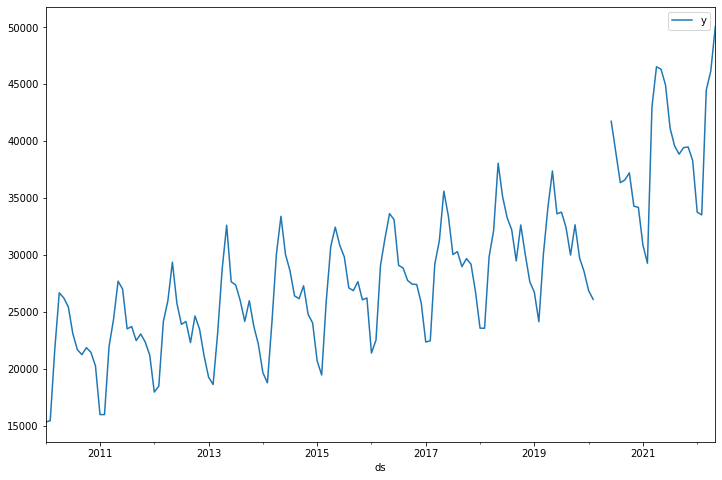

In [12]:
df.plot(x='ds', y='y', figsize=(12,8))

In [13]:
season_mode = "additive"

In [14]:
# Facebook Prophet Model
model = Prophet(seasonality_mode=season_mode, daily_seasonality=False, weekly_seasonality=False)
model.fit(df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr7c6g8t/qijo3lhy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmr7c6g8t/nol95fhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69656', 'data', 'file=/tmp/tmpmr7c6g8t/qijo3lhy.json', 'init=/tmp/tmpmr7c6g8t/nol95fhf.json', 'output', 'file=/tmp/tmp588u55rg/prophet_model-20220725093106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:31:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:31:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
# Make future dates
future = model.make_future_dataframe(periods=68, freq='M')
future = future[future['ds'].dt.year <= datetime.now().year+6]
future

,ds
0,2010-01-31
1,2010-02-28
2,2010-03-31
3,2010-04-30
4,2010-05-31
...,...
212,2027-09-30
213,2027-10-31
214,2027-11-30
215,2027-12-31


In [16]:
# Forecast
forecast = model.predict(future)

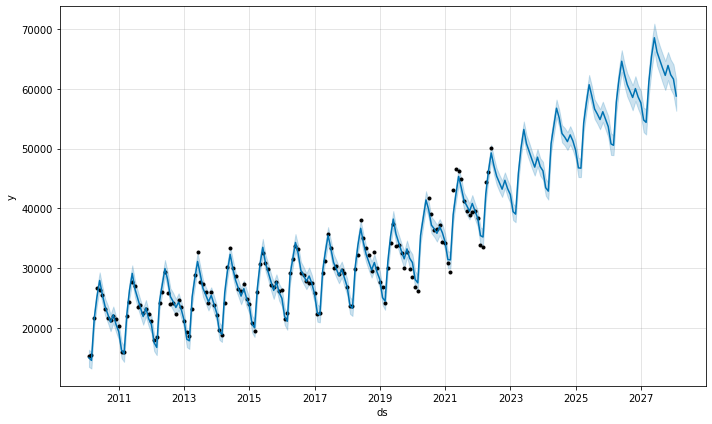

In [17]:
model.plot(forecast);

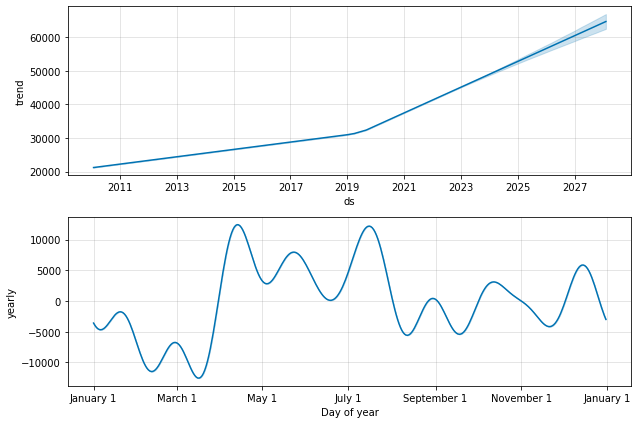

In [18]:
model.plot_components(forecast);

In [19]:
data_name = "Home Improvementt US"
forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']].to_csv(data_name+'-Prophet-Predictions.csv')